In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl
from torchvision import models
from datasets import BarcelonaDataModule


class VGG16TransferLearning(pl.LightningModule):
    def __init__(self, num_classes, lr_phase1=1e-4, lr_phase2=1e-5, fine_tune=False):
        super().__init__()
        self.save_hyperparameters()

        self.model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        #self.model.classifier[6] = nn.Linear(4096, num_classes)
        self.model.avgpool =  nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.model.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features=256, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=256, out_features=64, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=64, out_features=num_classes, bias=True)
        )

        for param in self.model.features.parameters():
            param.requires_grad = False

        if fine_tune:
            for param in self.model.features[-4:].parameters():
                param.requires_grad = True

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_acc", acc, on_epoch=True)

    def configure_optimizers(self):
        lr = self.hparams.lr_phase2 if self.hparams.fine_tune else self.hparams.lr_phase1
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=lr)
        # [p for p in self.parameters() if p.requires_grad]
        return optimizer

In [4]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

# Chargement des données
data_module = BarcelonaDataModule(root="barcelona", batch_size=32, num_workers=0)
data_module.prepare_data()
data_module.setup()
num_classes = len(data_module.train_ds.classes)

# Phase 1 : Transfer learning (couches gelées)
model_phase1 = VGG16TransferLearning(num_classes=num_classes, fine_tune=False)
trainer = Trainer(max_epochs=5, accelerator="gpu", devices=1)
trainer.fit(model_phase1, datamodule=data_module)

# Phase 2 : Fine-tuning (dé-gel partiel)
model_phase2 = VGG16TransferLearning(num_classes=num_classes, fine_tune=True)
model_phase2.model.load_state_dict(model_phase1.model.state_dict())  # transfert des poids
trainer = Trainer(max_epochs=5, accelerator="gpu", devices=1)
trainer.fit(model_phase2, datamodule=data_module)

# Évaluation finale
trainer.test(model_phase2, datamodule=data_module)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | VGG              | 14.9 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
148 K     Trainable params
14.7 M    Non-trainable params
14.9 M    Total params
59.452    Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | VGG              | 14.9 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
2.5 M     Trainable params
12.4 M    Non-trainable params
14.9 M    Total params
59.452    Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.942011833190918
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.942011833190918}]

In [5]:
# Sauvegarde après l'entraînement Phase 1
trainer.save_checkpoint("model_phase1.ckpt")

# Sauvegarde après l'entraînement Phase 2
trainer.save_checkpoint("model_phase2.ckpt")


In [13]:
# Charger model_phase1
model_phase1 = VGG16TransferLearning.load_from_checkpoint("model_phase1.ckpt")

# Charger model_phase2
model_phase2 = VGG16TransferLearning.load_from_checkpoint("model_phase2.ckpt")


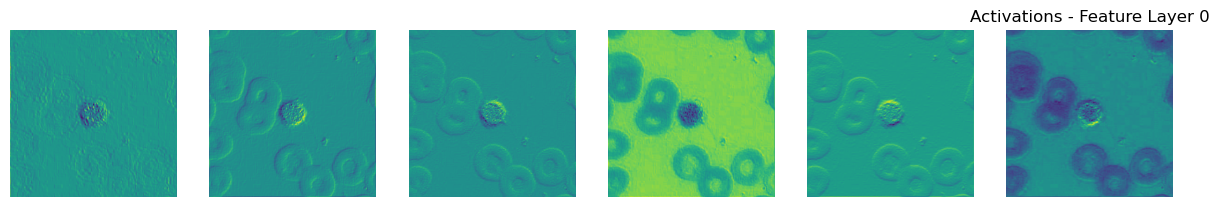

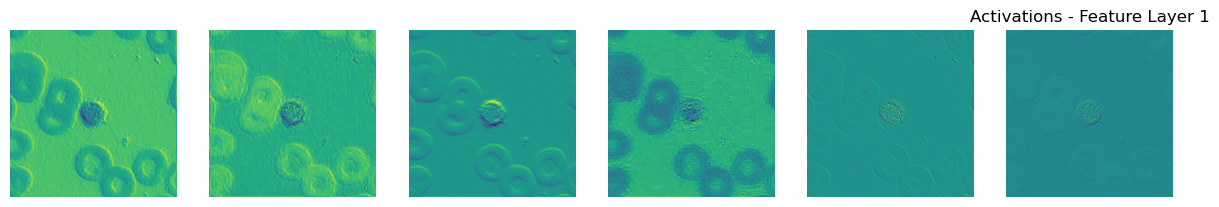

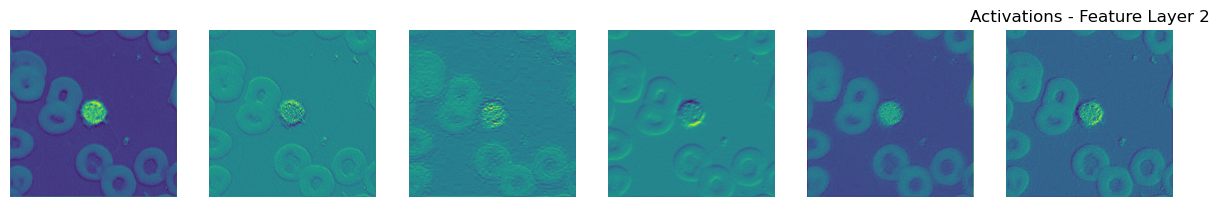

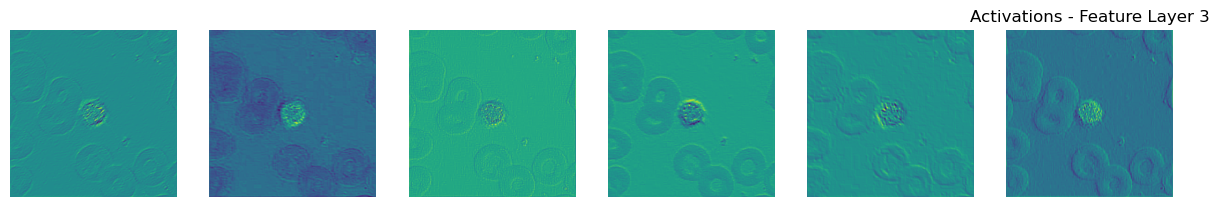

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random as rd

# Obtenir une image aléatoire depuis le dataset de validation
img, label = rd.choice(data_module.val_ds)
input_img = img.unsqueeze(0).to(model_phase1.device)  # batchify + envoyer sur le GPU

# Récupérer les 5 premières couches
mod = list(model_phase2.model.features.children())
layers = [mod[0], mod[2], mod[5], mod[7]]

# Stocker les activations
activations = []
x = input_img
for layer in layers:
    x = layer(x)
    activations.append(x)

# Fonction d'affichage des cartes d'activation
def show_feature_maps(feature_tensor, title, num_maps=6):
    feature_tensor = feature_tensor.squeeze(0).detach().cpu()
    num_maps = min(num_maps, feature_tensor.shape[0])
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 5))
    for i in range(num_maps):
        axes[i].imshow(feature_tensor[i])
        axes[i].axis('off')
    plt.title(title)
    plt.show()

# Afficher les activations
for i, act in enumerate(activations):
    show_feature_maps(act, title=f'Activations - Feature Layer {i}', num_maps=6)


In [3]:
model_phase2

VGG16TransferLearning(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.650465961792861e-08..1.000000028269751].


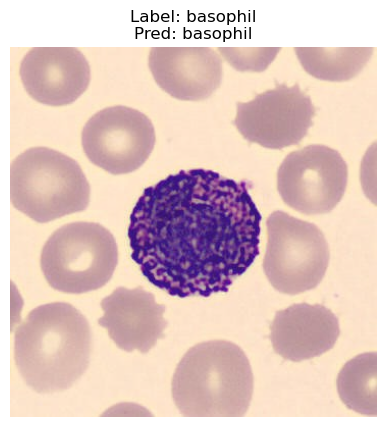

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.003921586722431147..1.000000028269751].


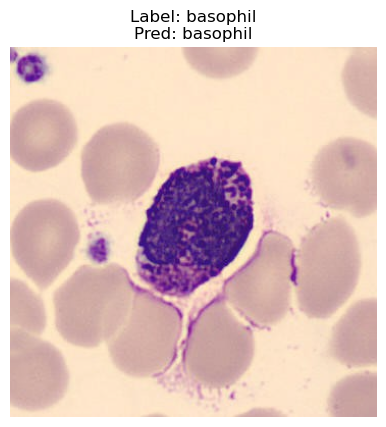

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.650465961792861e-08..1.000000028269751].


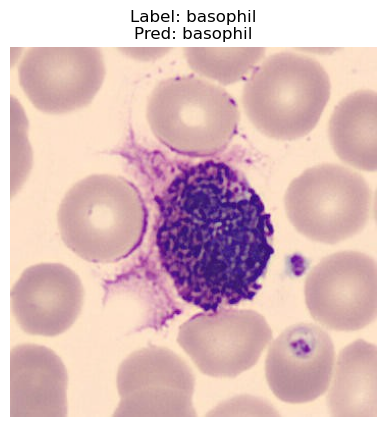

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.650465961792861e-08..1.000000028269751].


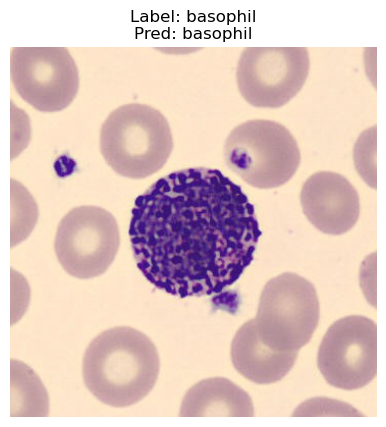

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.650465961792861e-08..1.000000028269751].


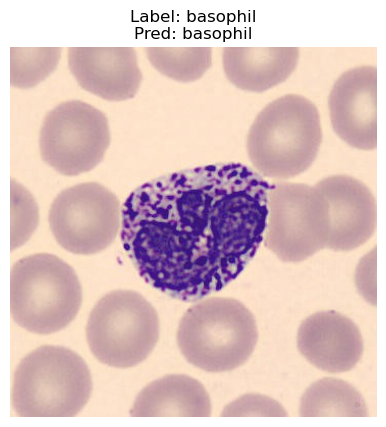

In [14]:
import matplotlib.pyplot as plt

classes = data_module.train_ds.classes

test_loader = data_module.test_dataloader()

def show_predictions(model, loader, n=5, device="cpu"):
    model.eval()
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images[:n].to(device)
    labels = labels[:n].to(device)

    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    for i in range(n):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * data_module.std + data_module.mean  # unnormalize
        plt.imshow(img)
        plt.title(f"Label: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
        plt.axis('off')
        plt.show()

show_predictions(model_phase2, test_loader)


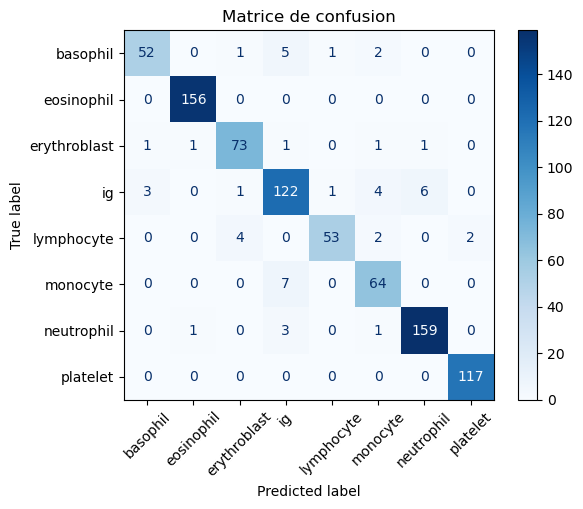

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def compute_confusion_matrix(model, dataloader, class_names, device="cpu"):
    all_preds = []
    all_labels = []

    model.eval()
    model.to(device)
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Matrice de confusion")
    plt.show()

# Exemple d’appel
compute_confusion_matrix(model_phase2, test_loader, data_module.train_ds.classes)